In [1]:
#Most of the code is from https://github.com/johnberroa

In [2]:
def distance(a,b):
    (x1,y1),(x2,y2) = (a,b)
    return np.sqrt((x1-x2)**2+(y1-y2)**2) 

def compare_sublists(l, lol):
        for sublist in lol:
            temp = [i for i in sublist if i in l]
            if sorted(temp) == sorted(l):
                return True
        return False
    
def readCSVFile(file):
    with open(file, newline='') as csvfile:
        _CITIES = list(csv.reader(csvfile))
    #print(_CITIES)
    _CITIES = np.delete(_CITIES, (0), axis=0)
    #print(_CITIES)
    return(_CITIES)

def getCoordinates(CITIES):
    _CITIES_POS = [ [x[1],x[2]] for x in _CITIES ]
    _CITIES_X=[x[0] for x in _CITIES_POS]
    _CITIES_Y=[y[1] for y in _CITIES_POS]
    return _CITIES_X,_CITIES_Y

def normalise_coord(_CITIES):

    _CITIES_POS = [ [x[1],x[2]] for x in _CITIES ]
    _CITIES_X=[x[0] for x in _CITIES_POS]
    _CITIES_Y=[y[1] for y in _CITIES_POS]

    #print(_CITIES_POS)
    #print(_CITIES_X)
    #print(_CITIES_Y)

    _CITIES_X=np.array(_CITIES_X)
    _CITIES_Y=np.array(_CITIES_Y)

    _CITIES_X = _CITIES_X.astype(np.float)
    _CITIES_Y = _CITIES_Y.astype(np.float)

    mean_x, mean_y = np.mean(_CITIES_X), np.mean(_CITIES_Y)
    std_x, std_y   = np.std(_CITIES_X), np.std(_CITIES_Y)

    #print(f"X\nMean : {mean_x}, Standard deviation : {mean_y}\n")
    #print(f"Y\nMean : {std_x}, Standard deviation : {std_y}")

    _CITIES_N_X= (_CITIES_X-mean_x)/std_x
    _CITIES_N_Y= (_CITIES_Y-mean_y)/std_y

    _CITIES_N = []
    for i in range(len(_CITIES_N_X)):
        _CITIES_N.append([i, _CITIES_N_X[i],_CITIES_N_Y[i]])

    _CITIES_N = (((_CITIES_N)))
    #print(_CITIES_N)
    #input()
    return _CITIES_N


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy.random as npr
import math as m
import random
import csv


import warnings

warnings.filterwarnings("ignore")


class AntColonyOptimizer:
    def __init__(self, ants, rho, intensification, alpha=1.0, beta=0.0, beta_decay=0,
                 exploitation=.1):
        """
        Ant colony optimizer.  Traverses a graph and finds either the max or min distance between nodes.
        :param ants: number of ants to traverse the graph
        :param ro: rate at which pheromone evaporates
        :param intensification: constant added to the best path
        :param alpha: weighting of pheromone
        :param beta: weighting of heuristic (1/distance)
        :param beta_decay: rate at which beta decays (optional)
        :param exploitation: probability to choose the best route
        """
        # Parameters
        self.ants = ants
        self.rho = rho
        self.reinforce_pheromone = intensification
        self.alpha = alpha
        self.beta = beta
        self.beta_decay = beta_decay
        self.exploitation = exploitation

        # Internal representations
        self.pheromone_matrix = None
        self.heuristic_matrix = None
        self.probability_matrix = None

        self.map = None
        self.allowed_nodes = None

        # Internal stats
        self.best_series = []
        self.best = None
        self.fitted = False
        self.best_path = None
        self.fit_time = None

        # Plotting values
        self.stopped_early = False

    def __str__(self):
        string = "Ant Colony Optimizer"
        string += "\n--------------------"
        string += "\nDesigned to optimize either the minimum or maximum distance between nodes in a square matrix that behaves like a distance matrix."
        string += "\n--------------------"
        string += "\n Number of ants:\t\t\t\t{}".format(self.ants)
        string += "\n Rho:\t\t\t{}".format(self.rho)
        string += "\n Intensification factor:\t\t{}".format(self.reinforce_pheromone)
        string += "\n Alpha:\t\t\t{}".format(self.alpha)
        string += "\n Beta:\t\t\t\t{}".format(self.beta)
        string += "\n Beta decay rate:\t\t{}".format(self.beta_decay)
        string += "\n Choose Best Percentage:\t\t{}".format(self.exploitation)
        string += "\n--------------------"
        string += "\n USAGE:"
        string += "\n Number of ants influences how many paths are explored each iteration."
        string += "\n Alpha and beta affect how much influence the pheromones or the distance heuristic weigh an ants' decisions."
        string += "\n Beta decay reduces the influence of the visibility over time."
        string += "\n Choose best is a percentage of how often an ant will choose the best route over probabilistically choosing a route based on pheromones."
        string += "\n--------------------"
        if self.fitted:
            string += "\n\nThis optimizer has been fitted."
        else:
            string += "\n\nThis optimizer has NOT been fitted."
        return string

    def _initialize(self):
        """
        Initializes the model by creating the various matrices and generating the list of available nodes
        """
        assert self.map.shape[0] == self.map.shape[1]
        num_nodes = self.map.shape[0]
        self.pheromone_matrix = np.ones((num_nodes, num_nodes))
        # Remove the diagonal since there is no pheromone from node i to itself
        self.pheromone_matrix[np.eye(num_nodes) == 1] = 0
        self.heuristic_matrix = 1 / self.map
        self.probability_matrix = (self.pheromone_matrix ** self.alpha) * (
                self.heuristic_matrix ** self.beta)  # element by element multiplcation
        self.allowed_nodes = list(range(num_nodes))

    def _reinstate_nodes(self):
        """
        Resets available nodes to all nodes for the next iteration
        """
        self.allowed_nodes = list(range(self.map.shape[0]))

    def _update_probabilities(self):
        """
        After evaporation and intensification, the probability matrix needs to be updated.  This function
        does that.
        """
        self.probability_matrix = (self.pheromone_matrix ** self.alpha) * (
                self.heuristic_matrix ** self.beta)

    def _choose_next_node(self, from_node):
        """
        Chooses the next node based on probabilities.  If p < p_exploitation, then the best path is chosen, otherwise
        it is selected from a probability distribution weighted by the pheromone.
        :param from_node: the node the ant is coming from
        :return: index of the node the ant is going to
        """
        numerator = self.probability_matrix[from_node, self.allowed_nodes]
        
        if np.random.random() < self.exploitation:
            next_node = np.argmax(numerator)
        else:
            denominator = np.sum(numerator)
            probabilities = numerator / denominator
            next_node = np.random.choice(range(len(probabilities)), p=probabilities)
        return next_node

    def _remove_node(self, node):
        self.allowed_nodes.remove(node)

    def _evaluate(self, paths, mode):
        """
        Evaluates the solutions of the ants by adding up the distances between nodes.
        :param paths: solutions from the ants
        :param mode: max or min
        :return: x and y coordinates of the best path as a tuple, the best path, and the best score
        """
        scores = np.zeros(len(paths))
        coordinates_i = []
        coordinates_j = []
        for index, path in enumerate(paths):
            score = 0
            coords_i = []
            coords_j = []
            for i in range(len(path) - 1):
                coords_i.append(path[i])
                coords_j.append(path[i + 1])
                score += self.map[path[i], path[i + 1]]
            scores[index] = score
            coordinates_i.append(coords_i)
            coordinates_j.append(coords_j)
        if mode == 'min':
            best = np.argmin(scores)
        elif mode == 'max':
            best = np.argmax(scores)
        return (coordinates_i[best], coordinates_j[best]), paths[best], scores[best]

    def _evaporation(self):
        """
        Evaporate some pheromone as the inverse of the evaporation rate.  Also evaporates beta if desired.
        """
        self.pheromone_matrix *= (1 - self.rho)
        self.beta *= (1 - self.beta_decay)

    def _reinforce(self, best_coords):
        """
        Increases the pheromone by some scalar for the best route.
        :param best_coords: x and y (i and j) coordinates of the best route
        """
        i = best_coords[0]
        j = best_coords[1]
        self.pheromone_matrix[i, j] += self.reinforce_pheromone

    def fit(self, map_matrix, iterations=100, mode='min', early_stopping_count=20, verbose=False):
        """
        Fits the ACO to a specific map.  This was designed with the Traveling Salesman problem in mind.
        :param map_matrix: Distance matrix or some other matrix with similar properties
        :param iterations: number of iterations
        :param mode: whether to get the minimum path or maximum path
        :param early_stopping_count: how many iterations of the same score to make the algorithm stop early
        :return: the best score
        """
        if verbose: print("Beginning ACO Optimization with {} iterations...".format(iterations))
        self.map = map_matrix
        start = time.time()
        self._initialize()
        num_equal = 0

        for i in range(iterations):
            start_iter = time.time()
            paths = []
            path = []

            for ant in range(self.ants):
                current_node = self.allowed_nodes[np.random.randint(0, len(self.allowed_nodes))]
                start_node = current_node
                while True:
                    path.append(current_node)
                    self._remove_node(current_node)
                    if len(self.allowed_nodes) != 0:
                        current_node_index = self._choose_next_node(current_node)
                        current_node = self.allowed_nodes[current_node_index]
                    else:
                        break

                path.append(start_node)  # go back to start
                self._reinstate_nodes()
                paths.append(path)
                path = []

            best_path_coords, best_path, best_score = self._evaluate(paths, mode)

            if i == 0:
                best_score_so_far = best_score
            else:
                if mode == 'min':
                    if best_score < best_score_so_far:
                        best_score_so_far = best_score
                        self.best_path = best_path
                elif mode == 'max':
                    if best_score > best_score_so_far:
                        best_score_so_far = best_score
                        self.best_path = best_path

            if best_score == best_score_so_far:
                num_equal += 1
            else:
                num_equal = 0

            self.best_series.append(best_score)
            self._evaporation()
            self._reinforce(best_path_coords)
            self._update_probabilities()

            if verbose: print("Best score at iteration {}: {}; overall: {} ({}s)"
                              "".format(i, round(best_score, 2), round(best_score_so_far, 2),
                                        round(time.time() - start_iter)))

            if best_score == best_score_so_far and num_equal == early_stopping_count:
                self.stopped_early = True
                print("Stopping early due to {} iterations of the same score.".format(early_stopping_count))
                break

        self.fit_time = round(time.time() - start)
        self.fitted = True

        if mode == 'min':
            self.best = self.best_series[np.argmin(self.best_series)]
            if verbose: print(
                "ACO fitted.  Runtime: {} minutes.  Best score: {}".format(self.fit_time // 60, self.best))
            return self.best
        elif mode == 'max':
            self.best = self.best_series[np.argmax(self.best_series)]
            if verbose: print(
                "ACO fitted.  Runtime: {} minutes.  Best score: {}".format(self.fit_time // 60, self.best))
            return self.best
        else:
            raise ValueError("Invalid mode!  Choose 'min' or 'max'.")

    def plot(self):
        """
        Plots the score over time after the model has been fitted.
        :return: None if the model isn't fitted yet
        """
        if not self.fitted:
            print("Ant Colony Optimizer not fitted!  There exists nothing to plot.")
            return None
        else:
            fig, ax = plt.subplots(figsize=(20, 15))
            ax.plot(self.best_series, label="Best Run")
            ax.set_xlabel("Iteration")
            ax.set_ylabel("Performance")
            ax.text(.8, .6,
                    'Ants: {}\nEvap Rate: {}\nIntensify: {}\nAlpha: {}\nBeta: {}\nBeta Evap: {}\nChoose Best: {}\n\nFit Time: {}m{}'.format(
                        self.ants, self.rho, self.reinforce_pheromone, self.alpha,
                        self.beta, self.beta_decay, self.exploitation, self.fit_time // 60,
                        ["\nStopped Early!" if self.stopped_early else ""][0]),
                    bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10}, transform=ax.transAxes)
            ax.legend()
            plt.title("Ant Colony Optimization Results (best: {})".format(np.round(self.best, 2)))
            plt.show()
        
    def plot_path(self, path, _CITIES):
        pp,qq=getCoordinates(_CITIES)
        x=[pp[i] for i in path]
        y=[qq[i] for i in path]
        #print(path) 
        #print(x)
        
        plt.plot(x,y,'ro-')
        for i in range(len(_CITIES)): 
            label = f"{_CITIES[i][0]}"
            plt.annotate(label, # this is the text
                 (pp[i],qq[i]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')
    
    def print_pheromone(self):
        data = self.pheromone_matrix
        fig, ax = plt.subplots()
        im = ax.imshow(data, cmap=plt.get_cmap('hot'), interpolation='nearest',
                        vmin=np.min(data), vmax=np.max(data))
        fig.colorbar(im)
        plt.show()
        return 0

In [4]:
_CITIES=readCSVFile('TwentyCities.csv')
_CITIES=normalise_coord(_CITIES)
_NODES = len(_CITIES)
print(_NODES)
x,y=getCoordinates(_CITIES)

#plt.scatter(x,y)
#for i in range(len(_CITIES)): 
#    label = f"{_CITIES[i][0]}"
#    plt.annotate(label, # this is the text
#                 (x[i],y[i]), # these are the coordinates to position the label
#                 textcoords="offset points", # how to position the text
#                 xytext=(0,5), # distance from text to points (x,y)
#                 ha='center') 
#print(_CITIES)


20


Stopping early due to 20 iterations of the same score.
Ant Colony Optimizer
--------------------
Designed to optimize either the minimum or maximum distance between nodes in a square matrix that behaves like a distance matrix.
--------------------
 Number of ants:				15
 Rho:			0.2
 Intensification factor:		2
 Alpha:			0.6
 Beta:				1
 Beta decay rate:		0
 Choose Best Percentage:		0.1
--------------------
 USAGE:
 Number of ants influences how many paths are explored each iteration.
 Alpha and beta affect how much influence the pheromones or the distance heuristic weigh an ants' decisions.
 Beta decay reduces the influence of the visibility over time.
 Choose best is a percentage of how often an ant will choose the best route over probabilistically choosing a route based on pheromones.
--------------------

This optimizer has been fitted.
[17, 16, 10, 15, 14, 11, 4, 0, 19, 13, 12, 8, 7, 9, 2, 6, 1, 5, 3, 18, 17]
12.870689462588162


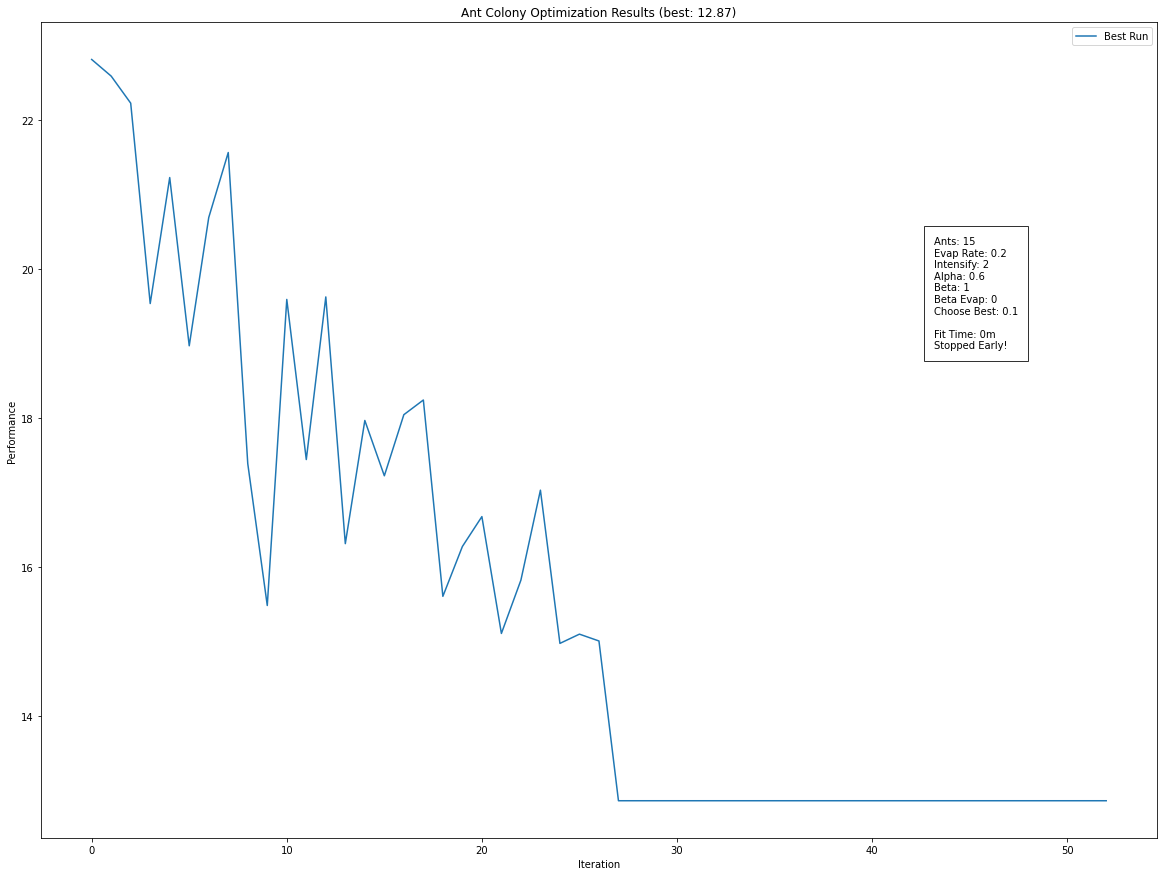

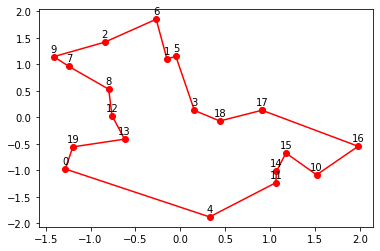

In [5]:

dist_matrix=np.zeros((_NODES,_NODES))
_CITIES_POS = [ [x[1],x[2]] for x in _CITIES ]
for i in range(_NODES):
    for j in range(_NODES):
        dist_matrix[i][j]=distance(_CITIES_POS[i],_CITIES_POS[j]) 
       
 #print(dist_matrix)     

optimizer = AntColonyOptimizer(ants=15, rho=.2, intensification=2, alpha=0.6, beta=1,
                               beta_decay=0, exploitation=.1)
 

best = optimizer.fit(dist_matrix, 100)

print(optimizer)

print(optimizer.best_path)
print(best)
optimizer.plot()
optimizer.plot_path(optimizer.best_path, _CITIES)
#optimizer.print_pheromone()